# Case: Predicting pipeline failure

![](https://russiabusinesstoday.com/wp-content/uploads/2018/07/gas-pipeline.jpg)

source: https://russiabusinesstoday.com/energy/new-technology-developed-in-russia-to-prevent-leaks-in-oil-pipelines/


Problem set:
* The current method of selecting a pipeline is based on manual selection and expert experience
* Often selected pipelines can vary from expert to expert

In [1]:
%pylab inline 
%load_ext autoreload
%autoreload 2

# external
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_style('whitegrid')
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: "%.5f"%x)

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv("../data/Pipeline_accidents.csv")

In [3]:
data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,accident_rate
0,-3.58732,2.82756,0.61315,1.78560,0.86683,-4.08761,1.76045,-4.93239,-1.50095,0.26589,-0.40599,-3.58595,2.41003,-0.33306,5.31568,-1.62066,0,1991.00000,2014.00000,1
1,0.12670,-1.65816,-0.61351,-3.60944,3.08006,6.00717,2.72879,-3.33571,0.13823,-0.65975,-0.19616,1.39748,-1.36438,0.78453,0.06152,3.54912,0,1992.00000,2013.00000,1
2,-0.11497,-0.08781,-1.63130,0.61358,-0.18274,2.21536,-1.20202,1.38636,-1.00715,-1.12576,-0.13575,0.33855,-1.18765,-0.10999,-1.60681,1.25900,0,1992.00000,2014.00000,1
3,-0.93918,-0.10740,-0.15290,-1.26467,-1.75252,2.53374,-1.00805,1.55743,1.65103,1.13717,-2.21030,-0.36551,-0.04281,-0.44820,1.54015,3.68052,0,1990.00000,2017.00000,1
4,-0.22160,4.55089,-3.52169,2.10049,-0.18616,-1.34608,3.50807,-0.42877,3.88768,-0.92489,0.65473,-0.13412,1.50138,3.50810,-1.12805,-0.14021,1,2005.00000,2013.00000,1


In [4]:
# check for missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1415 entries, 0 to 1414
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   x0             1415 non-null   float64
 1   x1             1415 non-null   float64
 2   x2             1415 non-null   float64
 3   x3             1415 non-null   float64
 4   x4             1415 non-null   float64
 5   x5             1415 non-null   float64
 6   x6             1415 non-null   float64
 7   x7             1415 non-null   float64
 8   x8             1415 non-null   float64
 9   x9             1415 non-null   float64
 10  x10            1415 non-null   float64
 11  x11            1415 non-null   float64
 12  x12            1415 non-null   float64
 13  x13            1415 non-null   float64
 14  x14            1415 non-null   float64
 15  x15            1415 non-null   float64
 16  x16            1415 non-null   int64  
 17  x17            1415 non-null   float64
 18  x18     

In [5]:
# inplace missing values
data.fillna(data.mean(), inplace=True)

In [6]:
# accident rate is a number of emergency repair for each 1 kilometer within reported year (X18 feature)
data['accident_rate'].value_counts()

1     845
2     284
3     122
4      63
5      40
6      21
7      15
8       9
10      5
9       5
11      4
12      2
Name: accident_rate, dtype: int64

# Binary classification approach

We will label all pipelines with the accident rate lower than 2 as class 0 and all other pipelines with class 1 - pipelines that require preventive maintenance

In [7]:
data['label'] = data['accident_rate'].apply(lambda x: 1 if x>1 else 0)
data.drop('accident_rate', axis=1, inplace=True)

In [8]:
# class balance
data['label'].value_counts()/data.shape[0]

0   0.59717
1   0.40283
Name: label, dtype: float64

In [9]:
features = [col for col in data.columns if 'x' in col]

## Metric

Is is important to keep False Positive predictions on the minimum but at the same time identiffy as much trouble pipeline as possible. So we could use combination of precision and recall - f-score metric

$\begin{equation*}\large
precision = \frac{True Positive}{True Positive + False Positive} 
\end{equation*}$

$\begin{equation*}\large
recall = \frac{True Positive}{True Positive + False Negative} 
\end{equation*}$

combining two metrics

$\begin{equation*}\large
F_1 = 2*\frac{precision*recall}{preciision + recall} 
\end{equation*}$

## Modeling

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

source: https://scikit-learn.org/stable/modules/cross_validation.html

In [10]:
data['x18'].value_counts()

2015.00000    345
2016.00000    340
2014.00000    312
2013.00000    233
2017.00000    185
Name: x18, dtype: int64

In [11]:
test = data[data['x18']>=2016]
train = data[data['x18']<2016]

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier()

cv_scores = cross_val_score(model, 
                            train[features].values, 
                            train['label'].values.reshape(-1,1),
                            cv=7,
                            scoring='f1'
                           )

In [15]:
cv_scores

array([0.9245283 , 1.        , 1.        , 1.        , 0.92307692,
       1.        , 0.8115942 ])

## Analysis of the results

In [16]:
model.fit(train[features].values, 
          train['label'].values.reshape(-1,1))

test['proba_prediction'] = model.predict_proba(test[features].values)[:,1]
test['binary_prediction'] = model.predict(test[features].values)

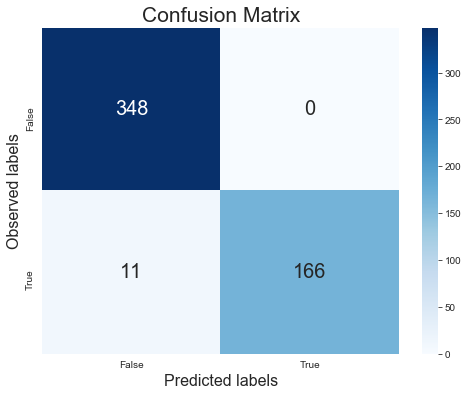

In [22]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

cm = confusion_matrix(test['label'].values, test['binary_prediction'].values)


fig, ax = pylab.subplots(figsize=(8, 6))
# sns.set(font_scale=2.0) # Adjust to fit
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g", annot_kws={"size": 20})  

# Labels, title and ticks
label_font = {'size':'16'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax.set_title('Confusion Matrix', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['False', 'True']);
ax.yaxis.set_ticklabels(['False', 'True']);

# Let's practice

Let's try to use regression instead of binary classification

In [25]:
data = pd.read_csv("../data/Pipeline_accidents.csv")

In [32]:
data.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,accident_rate
0,-3.58732,2.82756,0.61315,1.78560,0.86683,-4.08761,1.76045,-4.93239,-1.50095,0.26589,-0.40599,-3.58595,2.41003,-0.33306,5.31568,-1.62066,0,1991.00000,2014.00000,1
1,0.12670,-1.65816,-0.61351,-3.60944,3.08006,6.00717,2.72879,-3.33571,0.13823,-0.65975,-0.19616,1.39748,-1.36438,0.78453,0.06152,3.54912,0,1992.00000,2013.00000,1
2,-0.11497,-0.08781,-1.63130,0.61358,-0.18274,2.21536,-1.20202,1.38636,-1.00715,-1.12576,-0.13575,0.33855,-1.18765,-0.10999,-1.60681,1.25900,0,1992.00000,2014.00000,1
3,-0.93918,-0.10740,-0.15290,-1.26467,-1.75252,2.53374,-1.00805,1.55743,1.65103,1.13717,-2.21030,-0.36551,-0.04281,-0.44820,1.54015,3.68052,0,1990.00000,2017.00000,1
4,-0.22160,4.55089,-3.52169,2.10049,-0.18616,-1.34608,3.50807,-0.42877,3.88768,-0.92489,0.65473,-0.13412,1.50138,3.50810,-1.12805,-0.14021,1,2005.00000,2013.00000,1
